# A Simple Implementation Shortfall Strategy

Implementation shortfall attempts to balance the tradeoff between market impact (trading too aggressively) and opportunity cost (not trading or trading at worse prices later).  Put simply, it tries to achieve this by front loading trades (trading as much as possible early in the trade) subject to some risk factor.

## Target Function
We will define our target function as: 

y_t = 1 - b^t

where:
y_t = % complete at time 
t = time from arrival of the order
b = a risk aversion factor: 0 <= b <= 1

## Parameters
Parameters: &lt;side&gt; &lt;quantity&gt; [limit_px]  
side = "b" (buy) or "s" (sell)  
quantity = # of shares  
limit_px = limit price (optional)  
tolerance = shares behind we are willing to get

In [40]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.interpolation import shift
import pandas as pd
import time
import datetime

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

def show_time( label_string ):
    ts = time.time()
    st = datetime.datetime.fromtimestamp( ts ).strftime( '%Y-%m-%d %H:%M:%S:%f' )
    print( label_string + ' : ' + st )

In [41]:
def get_IS_targets( order_size, risk_coef ):
    minutes = np.arange( 0, 391 )
    # get percents
    pct_targets = 1 - risk_coef**minutes
    # calculate order size and round to 100
    targets = ( pct_targets * order_size ).astype(int)
    return targets

### Set up our market data

In [42]:
# load our taq file
taq = pd.read_pickle( 'TWTR_taq_20190131.gz' )

# get all the trades for later too
market_trades = pd.read_pickle ( 'TWTR_trades_201901.gz' )
market_trades = market_trades[ '2019-01-31' ]
market_trades = market_trades.between_time('09:30:00', '16:00:00')

### IS Simulation

In [69]:
order_side = "b"
order_quantity = 500000
risk_coef = 0.9
tolerance_threshold = 2500
clean_up_pct = 0.01 # percent of shares at which to trigger cleanup

# generate target schedule - use bins 1 - 390 giving an automatic 1 minute "look ahead"
# note that targets have been converted to shares from percent
order_targets = get_IS_targets( order_quantity, risk_coef )

# initialize some other variables
current_target = 0
current_bar = 0
quantity_filled = 0
quantity_remaining = order_quantity - quantity_filled
bid_price = 0.0
bid_quantity = 0
offer_price = 0.0
offer_quantity = 0
last_price = 0.0
last_quantity = 0.0
total_volume = 0
vwap_numerator = 0.0
trades_arr = []
passive_order_live = False
passive_order_price = 0.0
passive_order_quantity = 0
avg_spread = 0.05
round_lot = 100
order_arrival_price = 0.0
clean_up_shares = order_quantity * clean_up_pct

# main event loop
show_time( 'start loop' )
for index, row in taq.iterrows():
    # figure out which minute we are in after the open
    time_from_open = ( index - pd.Timedelta( hours = 9, minutes = 30 ) )
    minutes_from_open = ( time_from_open.hour * 60 ) + time_from_open.minute
        
    # MARKET DATA
    
    # determine message type
    if ( pd.isnull( row[ 'trade_qty' ] ) ): # it's a quote
        # collect BBO
        bid_price = row[ 'bid_price' ]
        offer_price = row[ 'ask_price' ]
        
        # simple arrival price calc as midpoint of first bid-ask. This is obviously highly imperfect
        if order_arrival_price == 0.0:
            order_arrival_price = ( bid_price + offer_price ) / 2
        
        # what's wrong with the lines below?
        bid_quantity = row[ 'bid_qty' ] * 100 
        offer_quantity = row[ 'ask_qty' ] * 100
    
    else: # it's a trade
        last_price = row[ 'trade_price' ]
        last_quantity = row[ 'trade_qty' ]
        
        # collect volume
        total_volume += last_quantity
        
        # collect rolling VWAP
        vwap_numerator += last_quantity * last_price
        
    # now check to see if we have an order open?
    if passive_order_live:
        # has our order been hit?
        if ( order_side == 'b' and last_price <= passive_order_price ) or ( order_side == 's' and last_price >= passive_order_price ):
            # we have a trade
            new_trade_quantity = min( last_quantity, passive_order_quantity )
            trades_arr.append( ( last_price, new_trade_quantity, current_bar, index, "p", quantity_behind ) )
            quantity_remaining = max( 0, quantity_remaining - new_trade_quantity )
            quantity_filled += new_trade_quantity  
            passive_order_live = False

    # are we in a new minute?
    if ( minutes_from_open > current_bar ):
        # we're in a new bar do new bar things here
        current_bar = minutes_from_open
        current_target = min( np.ceil( order_targets[ current_bar ] ), order_quantity )

        #print ( str(current_bar) + ': ' + str( current_target ) )
        
    # CLEANUP LOGIC
    
    # before we do anything else, if we're within one round lot, just finish the trade
    # assume for now there is sufficient liquidity to trade an odd lot
    if quantity_remaining <= clean_up_shares:
        show_time( "Entering cleanup. Quantity remaining: {0}".format( quantity_remaining ) )
        final_trade_quantity = quantity_remaining
        if ( order_side == 'b' ):
            final_trade_price = offer_price
        else: # we're selling
            final_trade_price = bid_price
        # update quantity remaining
        trades_arr.append( ( new_trade_price, new_trade_quantity, current_bar, index, "c", quantity_behind ) )
        quantity_remaining = max( 0, quantity_remaining - final_trade_quantity )
        quantity_filled += final_trade_quantity 
        
        # since we're supposed to be done, check that quantity remaining is now zero and if so, exit the loop
        if ( quantity_filled == order_quantity ) and ( quantity_remaining == 0 ):
            print( "We're Done" )
            break
        else:
            print( "ERROR: In cleanup logic but quantity remaining is not complete" )
            print( "Qty Remaining: {0}, Qty Filled: {1}, Order Size: {2}".format( quantity_remaining, quantity_filled, order_quantity ) )
            break
        
    # TRADE LOGIC
    
    # are we behind the target by more than our threshold? If so, do a trade, just pay the spread
    quantity_behind = current_target - quantity_filled
    
    # if we're less than a round lot behind no order, aggressive or passive.
    if quantity_behind < round_lot:
        continue
        
    # if we're over our threshold we need to trade now
    if ( quantity_behind > tolerance_threshold ): 
        
        # set trade size to the minimum of our target or visible liquidity on the BBO
        if ( order_side == 'b' ):
            new_trade_price = offer_price
            new_trade_quantity = min( quantity_behind, offer_quantity )
        else: # we're selling
            new_trade_price = bid_price
            new_trade_quantity = min( quantity_behind, bid_quantity )
            
        # round the trade quantity to smallest lot size
        new_trade_quantity = ( new_trade_quantity // round_lot ) * round_lot
            
        # do we have a valid last trade price? if not, we should skip, because market data is bad. 
        if ( new_trade_price == 0 ) or ( offer_price - bid_price > 5 * avg_spread ):
            # something is wrong, wait for market data to update
            continue
        
        if new_trade_quantity == 0: # something wrong
            print( "Error: quantity behind is {0} but aggressive trade size is: {1}".format( quantity_behind, new_trade_quantity ) )
            break
        
        # update quantity remaining
        trades_arr.append( ( new_trade_price, new_trade_quantity, current_bar, index, "a", quantity_behind ) )
        quantity_remaining = max( 0, quantity_remaining - new_trade_quantity )
        quantity_filled += new_trade_quantity    
        
        # we should cancel any passive orders since we just traded aggressively (we're assuming only one order at a time)
        passive_order_live = False
        
    else: # we should place a passive order (if we don't already have one out there), (unless we are less than 100 shares!)
        if ( passive_order_live == False ) and ( quantity_behind >= round_lot ):
            # this is our order so we can in theory place whatever size we want
            passive_order_quantity = quantity_behind
            if ( order_side == 'b' ):
                passive_order_price = bid_price
            else:
                passive_order_price = offer_price
            passive_order_live = True
        
# looping done
show_time( 'end simulation' )

start loop : 2019-04-25 20:43:37:852496
Entering cleanup. Quantity remaining: 4988.0 : 2019-04-25 20:45:05:153644
We're Done
end simulation : 2019-04-25 20:45:05:154497


In [70]:
# Now, let's look at some stats
#trades = trades.dropna()

trades_df = pd.DataFrame( trades_arr, columns=[ 'trade_price', 'trade_qty', 'bar', 'time', 'trade_type', 'quantity_behind' ] )
trades_df.index = pd.to_datetime( trades_df[ 'time' ] )
trades_df = trades_df.drop( columns = ['time'] )

In [71]:
day_vwap = vwap_numerator / total_volume
print( 'Trade statistics' )
print( 'stock volume: {0:,}'.format( int( total_volume ) ) )
print( 'order shares traded: {0:,}'.format( quantity_filled ) )
avg_price = (trades_df[ 'trade_price' ] * trades_df[ 'trade_qty' ]).sum() / trades_df[ 'trade_qty' ].sum()
print( 'average price: {0:.2f}'.format( avg_price ) )
print( 'order arrival price: {0:.2f}'.format( order_arrival_price ) )
print( 'day vwap: {0:.2f}'.format( day_vwap ) )
print( 'average trade size: {0:.2f}'.format( trades_df[ 'trade_qty' ].mean() ) )

Trade statistics
stock volume: 5,040,210
order shares traded: 500,000.0
average price: 33.10
order arrival price: 33.07
day vwap: 33.17
average trade size: 254.67


In [72]:
trades_df[ 'accum_shares' ] = trades_df[ 'trade_qty' ].cumsum()

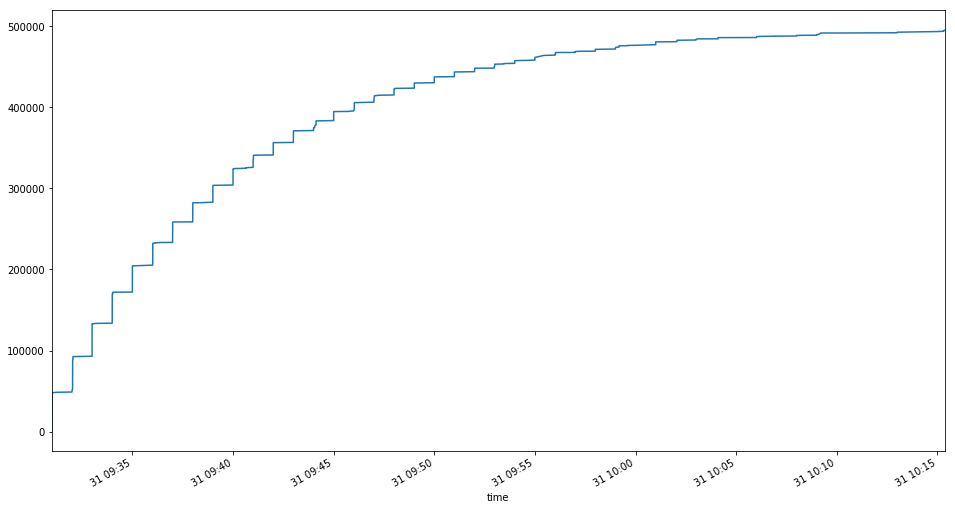

In [73]:
trades_df[ 'accum_shares' ].plot(figsize=(16,9))
plt.show()

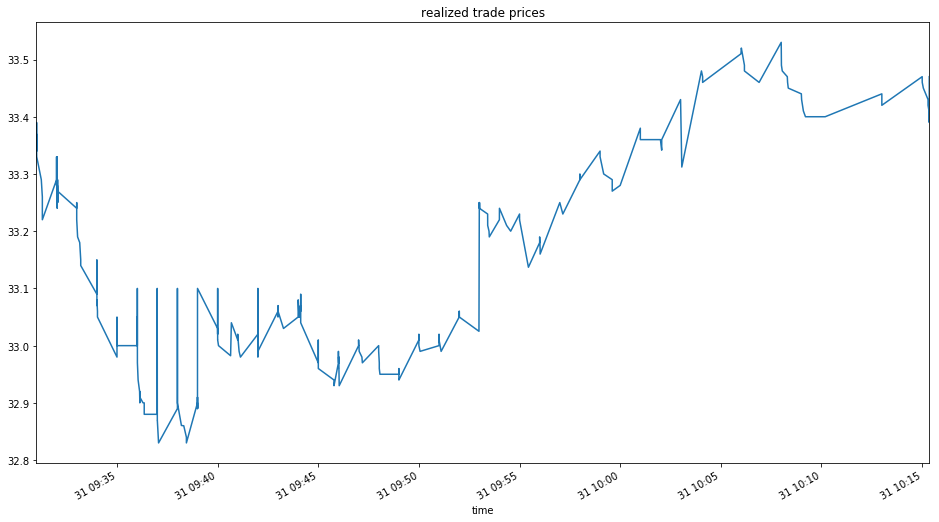

In [74]:
trades_df[ 'trade_price' ].plot( figsize = (16, 9) )
plt.title( 'realized trade prices' )
plt.show()

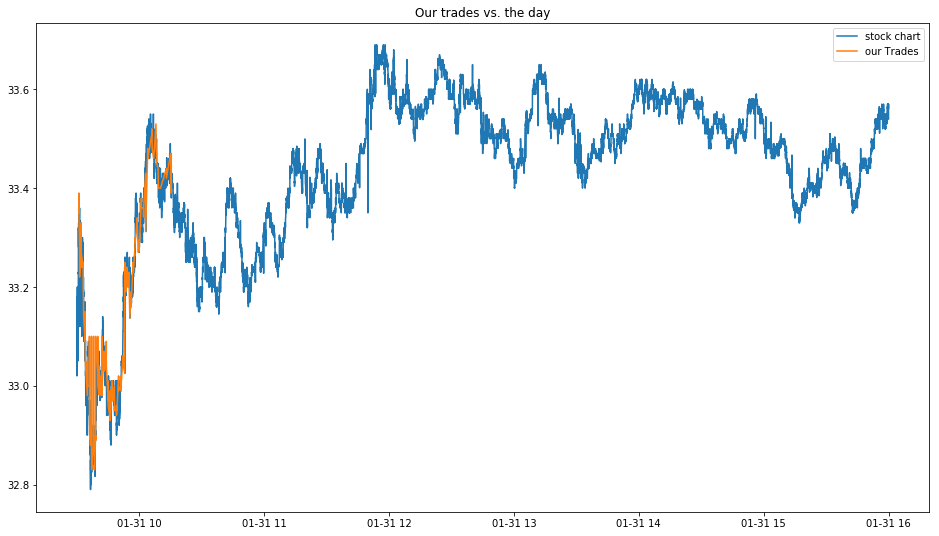

In [75]:
fig, ax1 = plt.subplots( figsize = ( 16, 9 ) )

ax1.plot( market_trades[ 'trade_price' ], label = 'stock chart' )
ax1.plot( trades_df[ 'trade_price' ], label = 'our Trades' )
plt.title( 'Our trades vs. the day' )
plt.legend()
plt.show()

In [76]:
trades_df.to_csv("trades250k-0.75-2000.csv")

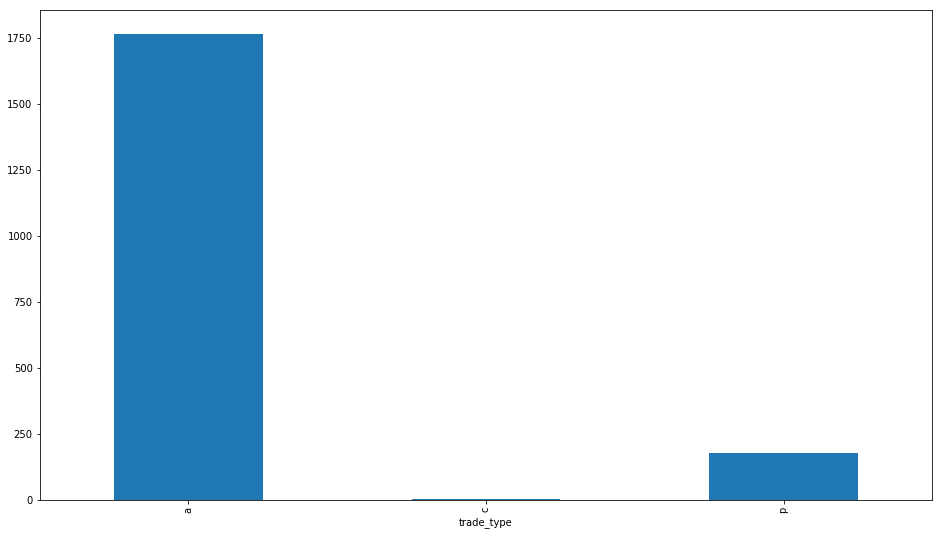

In [78]:
types = trades_df.groupby( [ 'trade_type' ] )[ 'trade_qty' ].count()
types.plot( kind = 'bar', figsize = (16, 9) )

In [68]:
len(trades_df)

1934